## Goal : How considering spherical coordinates impacts distance estimations and richness estimation

Note : has been done before knowing the way Matteo computes distances

In [1]:
import numpy as np
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
from clevar.cosmology import AstroPyCosmology
from astropy.cosmology import LambdaCDM
cosmo = AstroPyCosmology()
from clmm import Cosmology

/sps/lsst/users/namourou/conda_clone_021023/desc_v0/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/theory/__init__.py:91: UserWarning: CLMM Backend requested 'ccl' is not available, trying others...
/sps/lsst/users/namourou/conda_clone_021023/desc_v0/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/theory/__init__.py:96: UserWarning: * NumCosmo BACKEND also not available


In [2]:
cosmo_clevar = cosmo
cosmo_clevar_hand = LambdaCDM(H0= 70.0, Om0= 0.05 + 0.25, Ob0= 0.05, Tcmb0= 2.7255, Neff= 3.046, m_nu= ([0.06, 0.0, 0.0] * u.eV), Ode0=0.7)
cosmo_matteo = LambdaCDM(H0= 70.0, Om0= 0.3, Ode0=0.7)
cosmo_clmm =  Cosmology(H0=70.0, Omega_b0=0.05, Omega_dm0 = 0.25, Omega_k0=0.0)

In [4]:
cosmo_values = pd.read_csv('/pbs/home/n/namourou/workspace/side_codes/clusters/amico/verifications/verif_members/model_SUB_i_greta_t5_param.txt', sep="  ")
cosmo_values = Table.from_pandas(cosmo_values)

/tmp/ipykernel_2225/2900634211.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  cosmo_values = pd.read_csv('/pbs/home/n/namourou/workspace/side_codes/clusters/amico/verifications/verif_members/model_SUB_i_greta_t5_param.txt', sep="  ")


In [5]:
z_dist_matteo_params = cosmo_matteo.angular_diameter_distance(z=cosmo_values['z'])
z_dist_clevar_params_hand = cosmo_clevar_hand.angular_diameter_distance(z=cosmo_values['z'])
z_dist_clmm_params = cosmo_clmm.eval_da(cosmo_values['z'])

In [6]:
mb_inpath = '/sps/lsst/groups/clusters/amico_validation_project/catalogs/AMICO/raw_amico_cats/test_cosmoDC2_compute_lambstar/9559_map_associations_w_mag.fits'
raw_mb_inpath = '/sps/lsst/groups/clusters/amico_validation_project/catalogs/AMICO/raw_amico_cats/test_cosmoDC2_compute_lambstar/9559_map_associations_noBuffer.fits'
neighbours_path = '/sps/lsst/groups/clusters/amico_validation_project/catalogs/CosmoDC2/cosmodc2_neighbours.fits'
healpath = '/sps/lsst/users/tguillem/web/clusters/catalogs/cosmoDC2_photoz_flexzboost/v1/'
inpath = '/sps/lsst/groups/clusters/amico_validation_project/catalogs/AMICO/raw_amico_cats/test_cosmoDC2_compute_lambstar/9559_map_detections_refined_noBuffer.txt'
# = '/sps/lsst/groups/clusters/amico_validation_project/catalogs/AMICO/amico_cats/small/amico_map_associations/all_maps.fits'

In [7]:
cl_cat = pd.read_csv(inpath, sep="\t", header = 243)
cl_cat = Table.from_pandas(cl_cat)
mb = Table.read(mb_inpath)

In [8]:
cl = cl_cat[cl_cat['# ID']==119]
mbs_of_this_cl = mb[mb['ASSOC_ID']==119]
ra_cl, dec_cl, z_cl = cl['Xphys'], cl['Yphys'], cl['Zphys']
ra_mb, dec_mb, z_mb = mbs_of_this_cl['ra'], mbs_of_this_cl['dec'], mbs_of_this_cl['redshift']

In [9]:
ra_dist_clmm = cosmo_clmm.rad2mpc(abs(ra_cl[0]-ra_mb)*np.pi/180, z_cl[0])
dec_dist_clmm = cosmo_clmm.rad2mpc(abs(dec_cl[0]-dec_mb)*np.pi/180, z_cl[0])
z_dist_clmm = cosmo_clmm.eval_da(z=z_cl)-cosmo_clmm.eval_da(z=z_mb)

In [10]:
ra_dist_clevar = cosmo_clevar.rad2mpc(abs(ra_cl[0]-ra_mb)*np.pi/180, z_cl[0])
dec_dist_clevar = cosmo_clevar.rad2mpc(abs(dec_cl[0]-dec_mb)*np.pi/180, z_cl[0])
z_dist_clevar = cosmo_clevar.eval_da(z=z_cl)-cosmo_clevar.eval_da(z=z_mb)

In [11]:
#z_mb_r = [round(z_mb[i],2) for i in range(len(z_mb))]
#z_cl_r = round(z_cl[0],2)
#d_cl = cosmo_values[cosmo_values['z']==z_cl_r]['Dang[Mpc]']
#d_mb = cosmo_values[cosmo_values['z']==z_mb_r]['Dang[Mpc]']
z_dist_matteo = cosmo_matteo.angular_diameter_distance(z=z_cl)#-cosmo_matteo.angular_diameter_distance(z=z_mb)
#z_dist_clevar_hand = cosmo_clevar_hand.angular_diameter_distance(z=z_cl)-cosmo_clevar_hand.angular_diameter_distance(z=z_mb)

In [12]:
cos_distance = np.sin(dec_cl[0]*np.pi/180) * np.sin(dec_mb*np.pi/180) + np.cos(dec_cl[0]*np.pi/180) * np.cos(dec_mb*np.pi/180) * np.cos(ra_cl[0]*np.pi/180 - ra_mb*np.pi/180)
distance_angulaire = np.arccos(cos_distance)

In [13]:
distance_mpc = (z_dist_matteo*distance_angulaire).value
distance_mpc2 = cosmo_clmm.rad2mpc(distance_angulaire, z_cl[0])

Text(0, 0.5, 'Number of members')

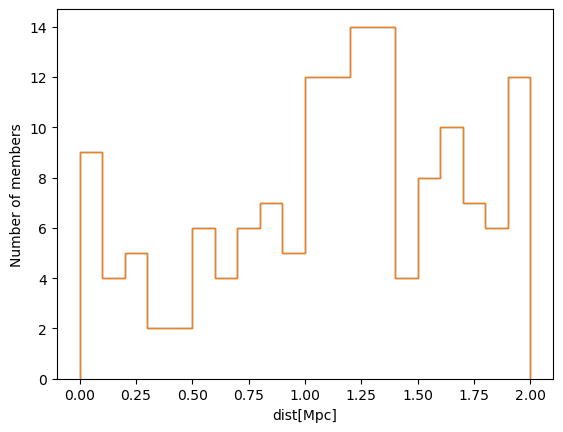

In [19]:
plt.hist(distance_mpc, bins = np.linspace(0,2.0, 21), histtype = 'step')
plt.hist(distance_mpc2, bins = np.linspace(0,2.0, 21), histtype = 'step')
plt.xlabel("dist[Mpc]")
plt.ylabel("Number of members")

In [21]:
cl = cl_cat[cl_cat['# ID']==119]
#cl["LAMBSTAR", "lambstarest_mpc"]

In [22]:
dist_clmm = np.sqrt((dec_dist_clmm)**2 + (dec_dist_clmm)**2)

In [23]:
len(distance_mpc)

158

In [24]:
len(dist_clmm)

158

Text(0, 0.5, 'Number of galaxies')

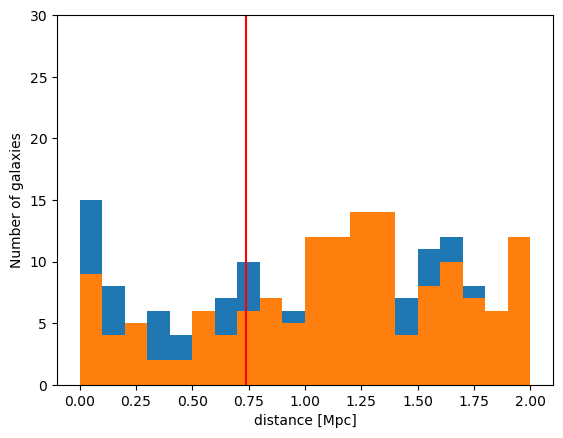

In [26]:
plt.hist(dist_clmm, bins = np.linspace(0,2.0, 21))
plt.hist(distance_mpc, bins = np.linspace(0,2.0, 21))
plt.vlines(cosmo_values[cosmo_values['z']==z_cl[0]]['r200[Mpc]'][0], 0,50, color='red')
plt.ylim([0,30])
plt.xlabel('distance [Mpc]')
plt.ylabel('Number of galaxies')

In [27]:
dist_ang = np.sqrt((ra_cl[0]-ra_mb)**2 + (dec_cl[0]-dec_mb)**2)

Text(0, 0.5, 'Number of galaxies')

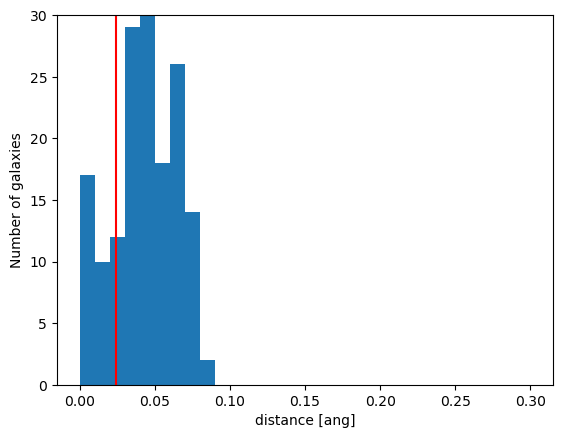

In [28]:
plt.hist(dist_ang, bins = np.linspace(0,0.3, 31))
plt.vlines(cosmo_values[cosmo_values['z']==z_cl[0]]['r200[deg]'], 0,50, color='red')
plt.ylim([0,30])
plt.xlabel('distance [ang]')
plt.ylabel('Number of galaxies')

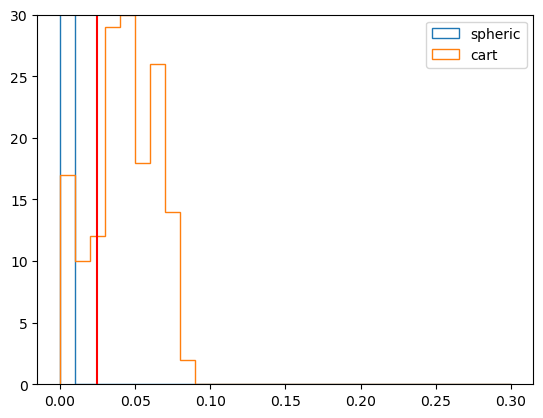

In [29]:
plt.hist(distance_angulaire, bins = np.linspace(0,0.3, 31), histtype = 'step',label = 'spheric')
plt.hist(dist_ang, bins = np.linspace(0,0.3, 31), histtype = 'step',label = 'cart')
plt.vlines(cosmo_values[cosmo_values['z']==z_cl[0]]['r200[deg]'], 0,50, color='red')
plt.ylim([0,30])
plt.legend()

In [30]:
print(len(dist_clmm), len(dist_ang), len(dist_clmm[dist_clmm<=cosmo_values[cosmo_values['z']==z_cl[0]]['r200[Mpc]'][0]]),
      len(dist_ang[dist_ang<=cosmo_values[cosmo_values['z']==z_cl[0]]['r200[deg]'][0]]), len(distance_angulaire[distance_angulaire<=cosmo_values[cosmo_values['z']==z_cl[0]]['r200[deg]'][0]]))

158 158 51 32 158


In [32]:
distance_mpc = distance_mpc

In [33]:
i, j, w, k, x, l, y = 0, 0, 0, 0, 0, 0, 0
cdt_mpc = dist_clmm[dist_clmm<=cosmo_values[cosmo_values['z']==z_cl[0]]['r200[Mpc]'][0]]
cdt_ang = dist_ang[dist_ang<=cosmo_values[cosmo_values['z']==z_cl[0]]['r200[deg]'][0]]
cdt_angsph = distance_angulaire[distance_angulaire<=cosmo_values[cosmo_values['z']==z_cl[0]]['r200[deg]'][0]]
cdt_mpcsph = distance_mpc[distance_mpc<=cosmo_values[cosmo_values['z']==z_cl[0]]['r200[Mpc]'][0]]
mbs_mpc_c = [mbs_of_this_cl[dist_clmm<=cosmo_values[cosmo_values['z']==z_cl[0]]['r200[Mpc]']]['GALID'][i] for i in range(len(cdt_mpc))]
mbs_ang_c = [mbs_of_this_cl[dist_ang<=cosmo_values[cosmo_values['z']==z_cl[0]]['r200[deg]']]['GALID'][i] for i in range(len(cdt_ang))]
mbs_angsph_c = [mbs_of_this_cl[distance_angulaire<=cosmo_values[cosmo_values['z']==z_cl[0]]['r200[deg]']]['GALID'][i] for i in range(len(cdt_angsph))]
mbs_mpcsph_c = [mbs_of_this_cl[distance_angulaire<=cosmo_values[cosmo_values['z']==z_cl[0]]['r200[Mpc]']]['GALID'][i] for i in range(len(cdt_mpcsph))]
for galidmb in mbs_of_this_cl['GALID']:
    if galidmb in mbs_mpc_c:
        i+=1
    if galidmb in mbs_ang_c:
        j+=1
    if galidmb in mbs_angsph_c:
        k+=1
    if galidmb in mbs_mpcsph_c:
        l+=1
    if galidmb in mbs_mpc_c and galidmb in mbs_ang_c:
        w +=1
    if galidmb in mbs_mpc_c and galidmb in mbs_ang_c:
        x +=1
    if galidmb in mbs_mpc_c and galidmb in mbs_mpcsph_c:
        y +=1

In [34]:
i,j,w,k ,x 

(51, 32, 26, 158, 26)

In [35]:
mb['dist_mpc'] = 0.0
mb['dist_deg'] = 0.0
mb['dist_degsph'] = 0.0
mb['dist_mpcsph'] = 0.0
for i, id in enumerate(cl_cat['# ID']):
    if i%500==0:
        print(i)
    assoc_cl = cl_cat[cl_cat['# ID'] == id]
    assoc_mb = mb[mb['ASSOC_ID']==id]
    ra_cl = assoc_cl['Xphys']
    dec_cl = assoc_cl['Yphys']
    z_cl = assoc_cl['Zphys']
    ra_mb = assoc_mb['ra']
    dec_mb = assoc_mb['dec']
    z_mb = assoc_mb['redshift']
    ra_dist = cosmo_clmm.rad2mpc(abs(ra_cl[0]-ra_mb)*np.pi/180, z_cl[0])
    dec_dist = cosmo_clmm.rad2mpc(abs(dec_cl[0]-dec_mb)*np.pi/180, z_cl[0])
    dist_mpc =  np.sqrt((ra_dist)**2+(dec_dist)**2)
    ra_dist_ang = ra_cl - ra_mb
    dec_dist_ang = dec_cl - dec_mb
    dist_ang = np.sqrt((ra_dist_ang)**2+(dec_dist_ang)**2)
    cos_distance = np.sin(dec_cl[0]) * np.sin(dec_mb) + np.cos(dec_cl[0]) * np.cos(dec_mb) * np.cos(ra_cl[0] - ra_mb)
    dist_angsph = np.arccos(cos_distance)
    z_dist_matteo = cosmo_matteo.angular_diameter_distance(z=z_cl)
    dist_mpcsph = (dist_angsph * z_dist_matteo).value
    mb['dist_mpc'][mb['ASSOC_ID']==id] = dist_mpc
    mb['dist_deg'][mb['ASSOC_ID']==id] = dist_ang
    mb['dist_degsph'][mb['ASSOC_ID']==id] = dist_angsph
    mb['dist_mpcsph'][mb['ASSOC_ID']==id] = dist_mpcsph

0
500
1000
1500
2000
2500
3000
3500


In [36]:
zeros1 = np.zeros(12)
mb_c_mpc = Table(zeros1, names = ('GALID','FIELD_PROB', 'ASSOC_ID', 'ASSOC_PROB', 'ra', 'dec', 'redshift', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y'))
mb_c_deg = Table(zeros1, names = ('GALID','FIELD_PROB', 'ASSOC_ID', 'ASSOC_PROB', 'ra', 'dec', 'redshift', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y'))
mb_c_degsph = Table(zeros1, names = ('GALID','FIELD_PROB', 'ASSOC_ID', 'ASSOC_PROB', 'ra', 'dec', 'redshift', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y'))
mb_c_mpcsph = Table(zeros1, names = ('GALID','FIELD_PROB', 'ASSOC_ID', 'ASSOC_PROB', 'ra', 'dec', 'redshift', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y'))
for i in range(len(cosmo_values['z'])-1):
    if i%50==0:
        print(i)
    z_min = cosmo_values['z'][i]
    z_max = cosmo_values['z'][i+1]
    mag_i_max = cosmo_values['mstar'][i+1] + 1.5 
    r200_mpc = cosmo_values['r200[Mpc]'][i+1]
    r200_deg = cosmo_values['r200[deg]'][i+1]
    cdt_mpc = mb[(mb['redshift']<=z_max)*(mb['redshift']>=z_min)*(mb['mag_i']<mag_i_max)*(mb['dist_mpc']<r200_mpc)]
    cdt_deg = mb[(mb['redshift']<=z_max)*(mb['redshift']>=z_min)*(mb['mag_i']<mag_i_max)*(mb['dist_deg']<r200_deg)]
    cdt_degsph = mb[(mb['redshift']<=z_max)*(mb['redshift']>=z_min)*(mb['mag_i']<mag_i_max)*(mb['dist_degsph']<r200_deg)]
    cdt_mpcsph = mb[(mb['redshift']<=z_max)*(mb['redshift']>=z_min)*(mb['mag_i']<mag_i_max)*(mb['dist_mpcsph']<r200_mpc)]
    mb_c_mpc = vstack([mb_c_mpc, cdt_mpc])
    mb_c_deg = vstack([mb_c_deg, cdt_deg])
    mb_c_degsph = vstack([mb_c_degsph, cdt_degsph])
    mb_c_mpcsph = vstack([mb_c_mpcsph, cdt_mpcsph])

0
50
100
150
200


In [38]:
cl_cat['lambstarest_mpc'] = 0.0
cl_cat['lambstarest_nomsk_mpc'] = 0.0
cl_cat['lambstarest_deg'] = 0.0
cl_cat['lambstarest_nomsk_deg'] = 0.0
cl_cat['lambstarest_degsph'] = 0.0
cl_cat['lambstarest_nomsk_degsph'] = 0.0
cl_cat['lambstarest_mpcsph'] = 0.0
cl_cat['lambstarest_nomsk_mpcsph'] = 0.0
rich = []
for i, id in enumerate(cl_cat['# ID']):
    if i%1000==0:
        print(i)
    cl_cat['lambstarest_nomsk_mpc'][cl_cat['# ID'] == id] = sum(mb_c_mpc[mb_c_mpc['ASSOC_ID']==id]['ASSOC_PROB'])
    cl_cat['lambstarest_mpc'][cl_cat['# ID'] == id] = cl_cat['lambstarest_nomsk_mpc'][cl_cat['# ID']==id]/(1-cl_cat[cl_cat['# ID']==id]['MSKFRC'][0])
    cl_cat['lambstarest_nomsk_deg'][cl_cat['# ID'] == id] = sum(mb_c_deg[mb_c_deg['ASSOC_ID']==id]['ASSOC_PROB'])
    cl_cat['lambstarest_deg'][cl_cat['# ID'] == id] = cl_cat['lambstarest_nomsk_deg'][cl_cat['# ID']==id]/(1-cl_cat[cl_cat['# ID']==id]['MSKFRC'][0])
    cl_cat['lambstarest_nomsk_degsph'][cl_cat['# ID'] == id] = sum(mb_c_degsph[mb_c_degsph['ASSOC_ID']==id]['ASSOC_PROB'])
    cl_cat['lambstarest_degsph'][cl_cat['# ID'] == id] = cl_cat['lambstarest_nomsk_degsph'][cl_cat['# ID']==id]/(1-cl_cat[cl_cat['# ID']==id]['MSKFRC'][0])
    cl_cat['lambstarest_nomsk_mpcsph'][cl_cat['# ID'] == id] = sum(mb_c_mpcsph[mb_c_mpcsph['ASSOC_ID']==id]['ASSOC_PROB'])
    cl_cat['lambstarest_mpcsph'][cl_cat['# ID'] == id] = cl_cat['lambstarest_nomsk_mpcsph'][cl_cat['# ID']==id]/(1-cl_cat[cl_cat['# ID']==id]['MSKFRC'][0])

0
1000
2000
3000


In [40]:
mu_mpc = np.mean((cl_cat["LAMBSTAR"]-cl_cat["lambstarest_mpc"])/cl_cat["LAMBSTAR"])
mu_deg = np.mean((cl_cat["LAMBSTAR"]-cl_cat["lambstarest_deg"])/cl_cat["LAMBSTAR"])
mu_degsph = np.mean((cl_cat["LAMBSTAR"]-cl_cat["lambstarest_degsph"])/cl_cat["LAMBSTAR"])
mu_mpcsph = np.mean((cl_cat["LAMBSTAR"]-cl_cat["lambstarest_mpcsph"])/cl_cat["LAMBSTAR"])
print(mu_mpc, mu_deg, mu_degsph, mu_mpcsph)

0.02195131463335069 0.023507605823573592 -0.06303447909391924 0.9810533011391478


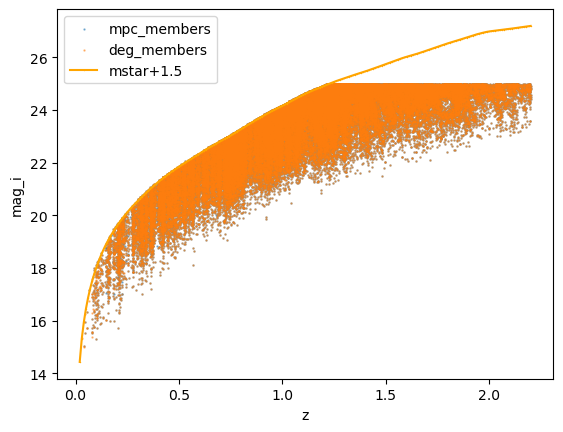

In [41]:
plt.scatter(mb_c_mpc['redshift'][1:], mb_c_mpc['mag_i'][1:], s = .5, alpha = .5, label = "mpc_members")
plt.scatter(mb_c_deg['redshift'][1:], mb_c_deg['mag_i'][1:], s = .5, alpha = .5, label = "deg_members")
plt.plot(cosmo_values['z'], cosmo_values['mstar']+1.5, marker = '+', markersize = .5, alpha = 1, color= 'orange', label = "mstar+1.5")
plt.xlabel("z")
plt.ylabel("mag_i")
plt.legend()